In [ ]:
!pip install wandb

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [1]:
import math
import wandb
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn import Module, LSTM, Linear, MSELoss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Data Preparation

In [2]:
class CryptoDataset(Dataset):
  """ Class to use for DataLoader """
  def __init__(self, X, y):
    self.X = X
    self.y = y
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

In [3]:
# ---- Data Load & Processing ---- #
# Load dataset
df = pd.read_feather(f'BTC.feather')
# Set `device` to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device set to {device}')
# Min-Max scale closing values
scaler = MinMaxScaler()
df['close'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Split into X sequence and y
X, y = [], []
# Split into rolling windows of 110 hours
L = 110 # Sequence Length, evenly divides 41,470
for i in range(df.shape[0]-L):
    X.append(df.iloc[i:(i+L)].close)
    y.append(df.iloc[i+L].close)

# --- TRAIN / VAL / TEST split --- #
X = np.array(X)
y = np.array(y)

train_size = int((1-0.33) * y.shape[0])
val_size = train_size - int(0.2 * train_size)

# Training is from start until validation index
X_train = X[:val_size]
y_train = y[:val_size]
# Validation is from validation index till end of training index
X_val = X[val_size:train_size]
y_val = y[val_size:train_size]
# Testing is from training index until end
X_test = X[train_size:]
y_test = y[train_size:]

# ---- Transform to ()num_layers, X.shape[0], hidden_state) shape ---- #
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_all = X.reshape(X.shape[0], X.shape[1], 1)
y_all = y.reshape(y.shape[0], 1)

Device set to cuda


In [57]:
# Initialize DataLoaders and move to `device`
BATCH_SIZE = 2000
NUM_WORKERS = 2
train_dl = DataLoader(
    CryptoDataset(X_train, y_train),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

validation_dl = DataLoader(
    CryptoDataset(X_val, y_val),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_dl = DataLoader(
    CryptoDataset(X_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

full_dl = DataLoader(
    CryptoDataset(X_all,y_all),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)



print(f'Train: {X_train.shape}\nValidation: {X_val.shape}\nTest: {X_test.shape}')

Train: (22169, 110, 1)
Validation: (5542, 110, 1)
Test: (13649, 110, 1)


## Model Define & Train

In [5]:
class LSTMRNN(Module):
    """
    Long Short-Term Memory Recurrent Neural Network.
    """

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTMRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_layers = num_layers

        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size,
                         num_layers=num_layers, batch_first=True)
        self.fc = Linear(hidden_size, num_classes)
        
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate RNN
        _, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out


In [6]:
def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor):
  _pred_scaled = scaler.inverse_transform(y_pred.cpu().data.numpy())
  _true_scaled = scaler.inverse_transform(y_true.cpu().data.numpy())
  return np.mean(1 - abs((_pred_scaled-_true_scaled)/_true_scaled))

In [7]:
# ---- TRAINING ---- #
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1


wandb.init(project="Crypto_LSTM", entity="spattni", name='BTC_LSTM')
config = {
    'epochs': 2000,
    'learning_rate': 0.001,
    'architecture': 'LSTM'
}
wandb.config = config

def train_model():
  n_steps_per_epoch = math.ceil(len(train_dl.dataset) / BATCH_SIZE)
  lstm = LSTMRNN(num_classes, input_size, hidden_size, num_layers)
  # Loss Function
  criterion = MSELoss()
  # Monitor Gradients
  wandb.watch(lstm, log_freq=100)
  # Move model to `device`
  lstm.to(device)

  optimizer = Adam(lstm.parameters(), lr=wandb.config['learning_rate'])
  for epoch in tqdm(range(wandb.config['epochs'])):
    lstm.train() # Set state to training
    for step, (inputs, targets) in enumerate(train_dl):
      # Move to `device` and convert to `float`
      inputs = inputs.to(device).float()
      targets = targets.to(device).float()
      optimizer.zero_grad() # Clear gradients
      yhat = lstm(inputs)
      loss = criterion(yhat, targets)
      _acc = calculate_accuracy(yhat, targets)

      # To Log to Weights & Biases
      train_metrics = {
          'train/train_loss': loss.item(),
          'train/epoch': (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
          'train/train_accuracy': _acc
      }

      # Backpropogate
      loss.backward()
      optimizer.step()
    
    lstm.eval() # Set state to inference
    with torch.no_grad():
      for step, (inputs, targets) in enumerate(validation_dl):
        # Move to `device` and convert to `float`
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()
        yhat = lstm(inputs)
        loss = criterion(yhat, targets)
        _acc = calculate_accuracy(yhat, targets)

        # To Log to Weights & Biases
        val_metrics = {
          'val/val_loss': loss.item(),
          'val/epoch': (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
          'val/val_accuracy': _acc
      }
    
    # Log
    wandb.log({**train_metrics, **val_metrics})
  wandb.finish()
  return lstm

model = train_model()
# count = 5
# wandb.agent(sweep_id, function=train_model, count=count)

wandb: Currently logged in as: spattni. Use `wandb login --relogin` to force relogin


100%|██████████| 2000/2000 [19:44<00:00,  1.69it/s]


train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_accuracy,▁▃▇▇███████████▇████████████████████████
train/train_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/val_accuracy,▁▃██████████████████████████████████████
val/val_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,2000.0
train/train_accuracy,0.99601
train/train_loss,0.0
val/epoch,1999.25
val/val_accuracy,0.99575


## Model Inference

In [58]:
def evaluate_model(model, test_dl):
  predictions, accuracy = [], []
  model.eval()
  with torch.no_grad():
    for step, (inputs, targets) in enumerate(test_dl):
      # Move to `device` and convert to `float`
      inputs = inputs.to(device).float()
      targets = targets.to(device).float()
      yhat = model(inputs)
      _acc = calculate_accuracy(yhat, targets)
      accuracy.append(_acc)
      predictions.extend(yhat.cpu().numpy())
  return np.array(predictions), np.mean(accuracy)

### Inference on Full Dataset (with Train/Test segregation)

Accuracy: 96.64%


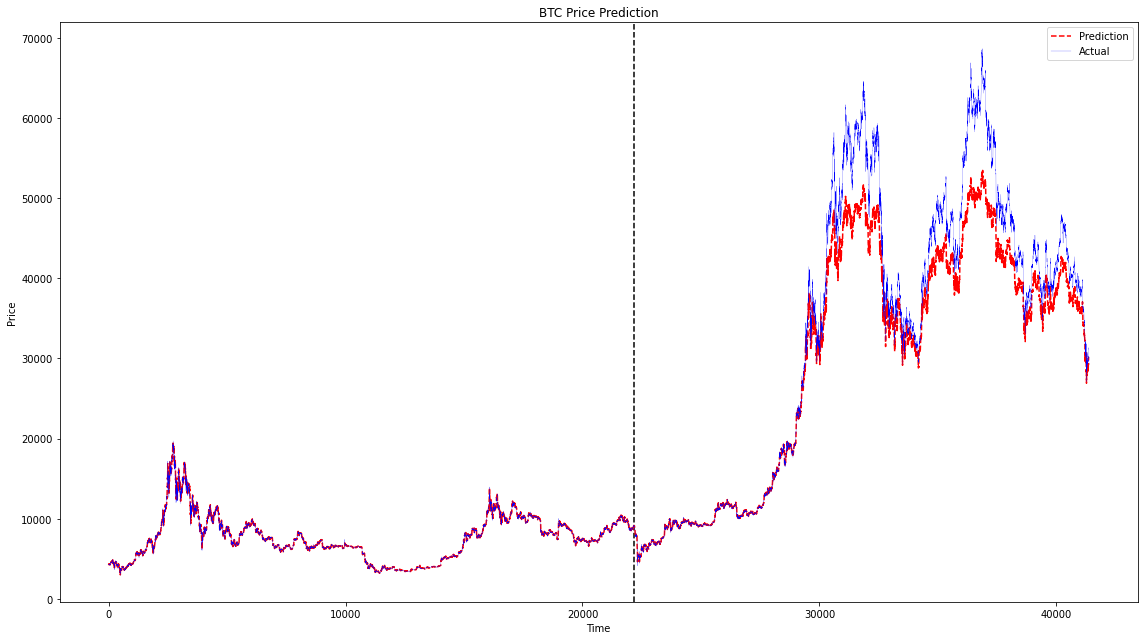

In [59]:
# ---- TESTING ---- #
pred, acc = evaluate_model(model, full_dl)
data_predict = scaler.inverse_transform(pred)
y_all_plot = scaler.inverse_transform(y_all)
_, _ = plt.subplots(figsize=(16,9))
plt.axvline(x=X_train.shape[0], color='k', linestyle='--')
plt.plot(data_predict, '--', label='Prediction', color='r')
plt.plot(y_all_plot, label='Actual', color='b', linewidth=0.2)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('BTC Price Prediction')
plt.legend()
plt.tight_layout()
print(f'Accuracy: {acc*100:,.2f}%')
plt.show()

### Inference on Test Data Only

Accuracy: 91.35%


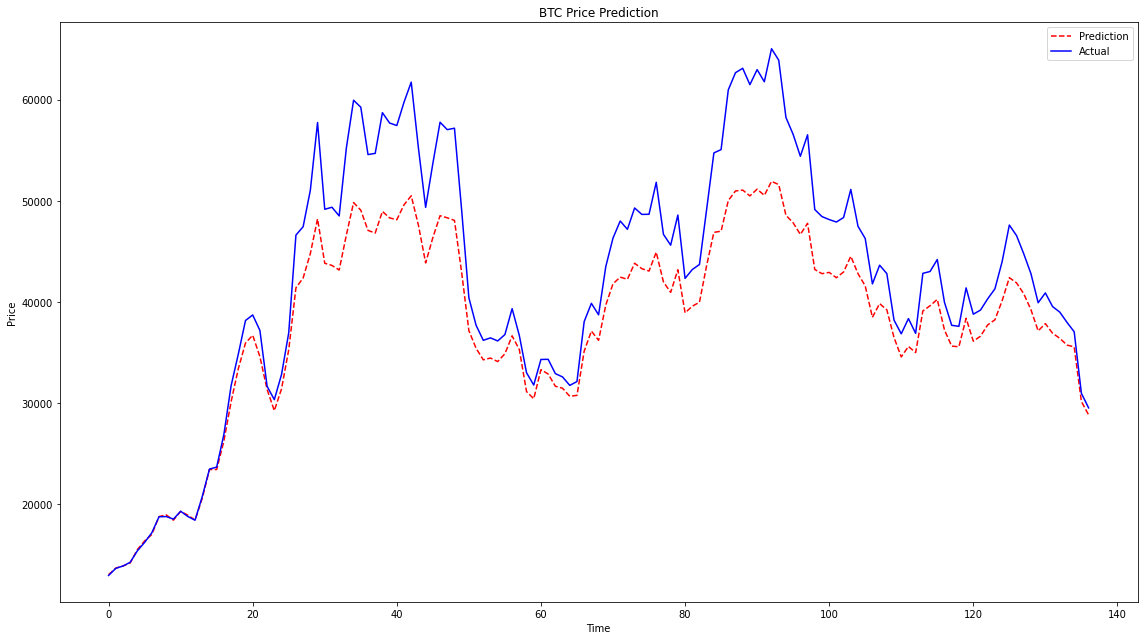

In [60]:
# ---- TESTING ---- #
pred, acc = evaluate_model(model, test_dl)
data_predict = scaler.inverse_transform(pred)
y_all_plot = scaler.inverse_transform(y_test)
_, _ = plt.subplots(figsize=(16,9))
plt.plot(data_predict[::100], '--', label='Prediction', color='r')
plt.plot(y_all_plot[::100], label='Actual', color='b')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('BTC Price Prediction')
plt.legend()
plt.tight_layout()
print(f'Accuracy: {acc*100:,.2f}%')
plt.show()